In [9]:
# Example for calibrating eye tracking data from a Beignet recording session
# Also generates plots to evaluate eye tracking calibration quality
#
# Following example in: http://aolab.wanprc.washington.edu:8888/notebooks/sijia/eyetracking_double_eye_session2337.ipynb
# Using eye tracking calibration functions in analyze/aopy/preproc.py

import os
import numpy as np
import aopy
import matplotlib.pyplot as plt

In [10]:
# Use relevant eye tracking files, in this example use data from Beignet, session te2337

# directory and filename for preprocessed data
preprocessed_dir = "/data/preprocessed/beignet"
# preprocessed_filename = 'preprocessed_te2337.hdf'
preprocessed_filename = 'preprocessed_te3428.hdf'


# directory and filenames for raw data, for eye tracking need hdf and ecube data
raw_dir = "/data/raw"

# Note these paths can also be found in the preprocessed metadata, through:
# metadata = aopy.data.load_hdf_group(base_dir, preprocessed_filename, 'exp_metadata')
# raw_filenames = metadata['source_files']
# raw_filenames = {
#     "hdf": "hdf/beig20210806_16_te2337.hdf",
#     "ecube": "ecube/2021-08-06_BMI3D_te2337",
# }

raw_filenames = {
    "hdf": "hdf/beig20211207_03_te3428.hdf",
    "ecube": "ecube/2021-12-07_BMI3D_te3428",
}


In [11]:
# Call eye data processing, calculates calibrations and applies it
# Don't save results into filesystem
eye_data, eye_metadata = aopy.preproc.proc_eyetracking(
    data_dir=raw_dir,
    files=raw_filenames,
    result_dir=preprocessed_dir,
    result_filename=preprocessed_filename,
    overwrite=True,
    save_res=False
)

use bmi3d supplied eye channel definition [10, 11, 8, 9]
Using 135 cursor x,y positions to calibrate eye tracking data


/home/aolab/miniconda3/envs/patrick-analysis/lib/python3.9/site-packages/aopy/analysis.py:762: UserWarning: when fitting column number 0, the correlation coefficient is 0.003954923923937491, less than 0.5 
  warnings.warn(f'when fitting column number {i}, the correlation coefficient is {corr_coeff[i]}, less than {coefficient_coeff_warning_level} ')
/home/aolab/miniconda3/envs/patrick-analysis/lib/python3.9/site-packages/aopy/analysis.py:762: UserWarning: when fitting column number 1, the correlation coefficient is -0.009938518861000287, less than 0.5 
  warnings.warn(f'when fitting column number {i}, the correlation coefficient is {corr_coeff[i]}, less than {coefficient_coeff_warning_level} ')
/home/aolab/miniconda3/envs/patrick-analysis/lib/python3.9/site-packages/aopy/analysis.py:762: UserWarning: when fitting column number 2, the correlation coefficient is -0.08055307626274609, less than 0.5 
  warnings.warn(f'when fitting column number {i}, the correlation coefficient is {corr_coef

In [14]:
# examine what the 2 dicts have returned
print(eye_data.keys())
print(eye_metadata.keys())

dict_keys(['raw_data', 'calibrated_data', 'coefficients', 'correlation_coeff', 'cursor_calibration_data', 'eye_calibration_data'])
dict_keys(['channels', 'labels', 'samplerate', 'voltsperbit'])


In [40]:
# Grab eye calibration and cursor calibration data for plots

# cursor_calibration_data: which cursor positions are used for calibration
# in N x 4, where N is the number of calibration points and 4 represents: 
# ['x_pos', 'y_pos', 'x_pos', 'y_pos'] Note: data is duplicated to match the 4 channels for eyes. 
cursor_calibration_data = eye_data["cursor_calibration_data"]

# eye_calibration_data: which eye positions (voltages) are used for calibration
# in N x 4, where N is the number of calibration points and 4 represents: 
# ['left_eye_x', 'left_eye_y', 'right_eye_x', 'right_eye_y], also specified in eye_metadata["labels"]
eye_calibration_data = eye_data["eye_calibration_data"]

# Examine their dimensions
print(eye_metadata["labels"])
print(cursor_calibration_data.shape)
print(eye_calibration_data.shape)

['left_eye_x', 'left_eye_y', 'right_eye_x', 'right_eye_y']
(135, 4)
(135, 4)


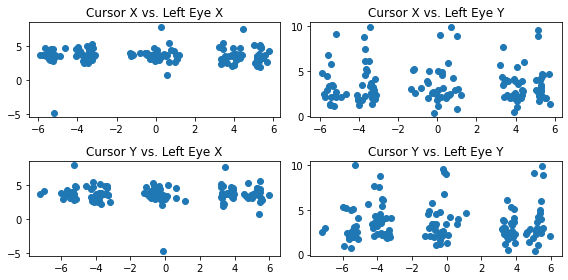

In [25]:
# plot relationship between X, Y position of both eyes and X, Y position of cursor for 
# data points chosen for calibration, 

# Left eye first
figure_scatter, axes_scatter = plt.subplots(2,2,figsize = (8,4))

axes_scatter[0,0].set_title('Cursor X vs. Left Eye X')
axes_scatter[0,0].scatter(cursor_calibration_data[:,0], eye_calibration_data[:,0], )

axes_scatter[0,1].set_title('Cursor X vs. Left Eye Y')
axes_scatter[0,1].scatter(cursor_calibration_data[:,0], eye_calibration_data[:,1], )

axes_scatter[1,0].set_title('Cursor Y vs. Left Eye X')
axes_scatter[1,0].scatter(cursor_calibration_data[:,1], eye_calibration_data[:,0], )

axes_scatter[1,1].set_title('Cursor Y vs. Left Eye Y')
axes_scatter[1,1].scatter(cursor_calibration_data[:,1], eye_calibration_data[:,1], )

figure_scatter.tight_layout()

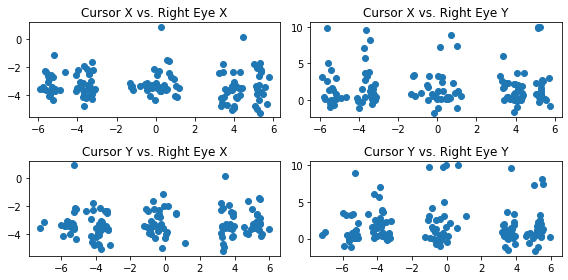

In [27]:
# Then Right eye

figure_scatter, axes_scatter = plt.subplots(2,2,figsize = (8,4))

axes_scatter[0,0].set_title('Cursor X vs. Right Eye X')
axes_scatter[0,0].scatter(cursor_calibration_data[:,0], eye_calibration_data[:,2], )

axes_scatter[0,1].set_title('Cursor X vs. Right Eye Y')
axes_scatter[0,1].scatter(cursor_calibration_data[:,0], eye_calibration_data[:,3], )

axes_scatter[1,0].set_title('Cursor Y vs. Right Eye X')
axes_scatter[1,0].scatter(cursor_calibration_data[:,1], eye_calibration_data[:,2], )

axes_scatter[1,1].set_title('Cursor Y vs. Right Eye Y')
axes_scatter[1,1].scatter(cursor_calibration_data[:,1], eye_calibration_data[:,3], )

figure_scatter.tight_layout()

In [32]:
# Grab calculated calibration coefficients
# Calculate eye positions in monitor space

# Set print options downstream
np.set_printoptions(precision = 2)

# Given as 4 x 2, where 2 represents ['slope', 'intercept']
coefficients = eye_data["coefficients"]

correlation_coeff = eye_data["correlation_coeff"]
print(coefficients.shape)
print(correlation_coeff.shape)
# estimated eye positions in monitor space given by eye data * slope + intercept
estimated_cursor_aligned = coefficients[:, 0] * eye_calibration_data + coefficients[:, 1]
print(estimated_cursor_aligned.shape)


(4, 2)
(4,)
(135, 4)


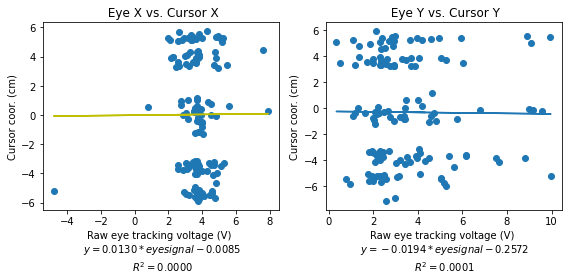

In [35]:
# plot position of cursor and estimated eye position in monitor space relative to raw eye position (in voltages)
# for data points chosen for calibration.

# Left eye

figure_scatter_fit, axes_scatter_fit = plt.subplots(1,2,figsize = (8,4))

axes_scatter_fit[0].set_title('Left Eye X vs. Cursor X')
axes_scatter_fit[0].scatter( eye_calibration_data[:,0], cursor_calibration_data[:,0])
axes_scatter_fit[0].plot( eye_calibration_data[:,0], estimated_cursor_aligned[:, 0], color = 'y')
axes_scatter_fit[0].set_xlabel(f'Raw eye tracking voltage (V) \n $y = {coefficients[0, 0]:.4f} *eye signal {coefficients[0, 1]:.4f}$ \n $R^2 = {correlation_coeff[0]**2:.4f}$ ')
axes_scatter_fit[0].set_ylabel('Cursor coor. (cm)')

axes_scatter_fit[1].set_title('Left Eye Y vs. Cursor Y')
axes_scatter_fit[1].scatter( eye_calibration_data[:,1], cursor_calibration_data[:,1])
axes_scatter_fit[1].plot( eye_calibration_data[:,1], estimated_cursor_aligned[:, 1])
axes_scatter_fit[1].set_xlabel(f'Raw eye tracking voltage (V) \n $y = {coefficients[1, 0]:.4f} *eye signal {coefficients[1, 1]:.4f}$ \n $R^2 = {correlation_coeff[1]**2:.4f}$ ')
axes_scatter_fit[1].set_ylabel('Cursor coor. (cm)')

figure_scatter_fit.tight_layout()

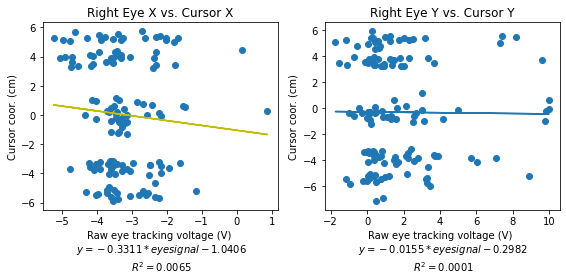

In [36]:
# Plot for right eye

figure_scatter_fit, axes_scatter_fit = plt.subplots(1,2,figsize = (8,4))

axes_scatter_fit[0].set_title('Right Eye X vs. Cursor X')
axes_scatter_fit[0].scatter( eye_calibration_data[:,2], cursor_calibration_data[:,0])
axes_scatter_fit[0].plot( eye_calibration_data[:,2], estimated_cursor_aligned[:, 2], color = 'y')
axes_scatter_fit[0].set_xlabel(f'Raw eye tracking voltage (V) \n $y = {coefficients[2, 0]:.4f} *eye signal {coefficients[2, 1]:.4f}$ \n $R^2 = {correlation_coeff[2]**2:.4f}$ ')
axes_scatter_fit[0].set_ylabel('Cursor coor. (cm)')

axes_scatter_fit[1].set_title('Right Eye Y vs. Cursor Y')
axes_scatter_fit[1].scatter( eye_calibration_data[:,3], cursor_calibration_data[:,1])
axes_scatter_fit[1].plot( eye_calibration_data[:,3], estimated_cursor_aligned[:, 3])
axes_scatter_fit[1].set_xlabel(f'Raw eye tracking voltage (V) \n $y = {coefficients[3, 0]:.4f} *eye signal {coefficients[3, 1]:.4f}$ \n $R^2 = {correlation_coeff[3]**2:.4f}$ ')
axes_scatter_fit[1].set_ylabel('Cursor coor. (cm)')

figure_scatter_fit.tight_layout()